# Simulations with Noise and Errors

## Introduction
This notebook is the first in a series of tutorials about using `Pulser` to simulate pulse sequences with noise and errors. These are an unavoidable part of a real quantum system, and a good simulation of a pulse sequence should be able to reproduce accurately. A detailed explanation of these phenomena can be found in the following [reference](https://arxiv.org/abs/1802.10424).

Currently, `Pulser` includes _noises_ for the laser pulses and _errors_ for the state preparation and measurement stages:

### 1. SPAM (_State Preparation And Measurement_) errors:

- **State Preparation errors**: The initial state preparation can fail to trap all the atoms in the ground state $\ket{g}$. We model this with a probability $\eta$ of _not_ having a given atom during the processing.
- **Measurement errors**: In addition, the probabilities $\epsilon, \epsilon '$ are linked to detection errors. The first one is the probability of detecting an atom in the ground state $\Ket{g}$ as if it were in the excited state $\Ket{r}$ ("false positives"), and the second one is the probability of detecting an atom in the excited state $\Ket{r}$ as if it were in the ground state $\Ket{g}$ ("false negatives").

### 2. Laser noises:
The lasers themselves are also susceptible to fluctuations, as well as their effectiveness in producing the desired transitions in the atomic levels addressed:

- **Doppler damping**: The atoms in the register are cooled to a temperature $T \sim 50\mu K$, which is low but still non-zero. Therefore, the laser frequency they observe is shifted by Doppler shifting due to thermal motion. This corresponds to a shift in the detuning frequency of the laser, and leads to a damping in the Rydberg population.
- **Waist of the laser**: For global pulses, the laser amplitude has a Gaussian profile and atoms at the border of the waist feel a slightly lower amplitude than those at the focus.
- **Amplitude fluctuations**: Fluctuations in the laser amplitude from pulse to pulse. 

### 3. Effective noise channels:

More generally, we can include effective noise channels in our simulation. These can represent the aggregate of different noise sources, as well as an interaction with an environment. To include these in our simulations, we use the Lindblad master equation, an evolution equation for the _density matrix_ $\rho$ of the system. Some introductory lecture notes on the topic can be found [here](http://theory.caltech.edu/~preskill/ph219/chap3_15.pdf). `Pulser` includes the following noise channels:

- **Dephasing channel**: Implements a decay in the _coherence_ or _interference_ terms (the off-diagonal terms in $\rho$). It applies random $z$-rotations on each qubit according to a given probability $p$, the dephasing probability.
- **Depolarizing channel**: A more general type of noise in which $\rho$ loses information due to interactions with the environment. This is represented as an evolution towards the completely mixed state $\rho \rightarrow \frac{\mathbb{I}}{2}$, effectively erasing the coherence in $\rho$. The channel randomly changes $\rho$ with a probability $p$ into either a bit-flip, a phase-flip or both, and left unchanged with probability $1-p$.
- **Custom effective noise channel**: we can also include custom noise channels by providing the Lindblad operators and their coefficients.


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import qutip

from pulser import Register, Pulse, Sequence
from pulser_simulation import SimConfig, Simulation
from pulser.devices import Chadoq2
from pulser.waveforms import ConstantWaveform, RampWaveform

## Single atom noisy simulations

### Sequence preparation

Prepare a single atom:

In [19]:
reg = Register.from_coordinates([(0, 0)], prefix="q")

We act on this atom with a Constant Pulse, such that it oscillates between the excited Rydberg state and back to the original state (Rabi oscillations):

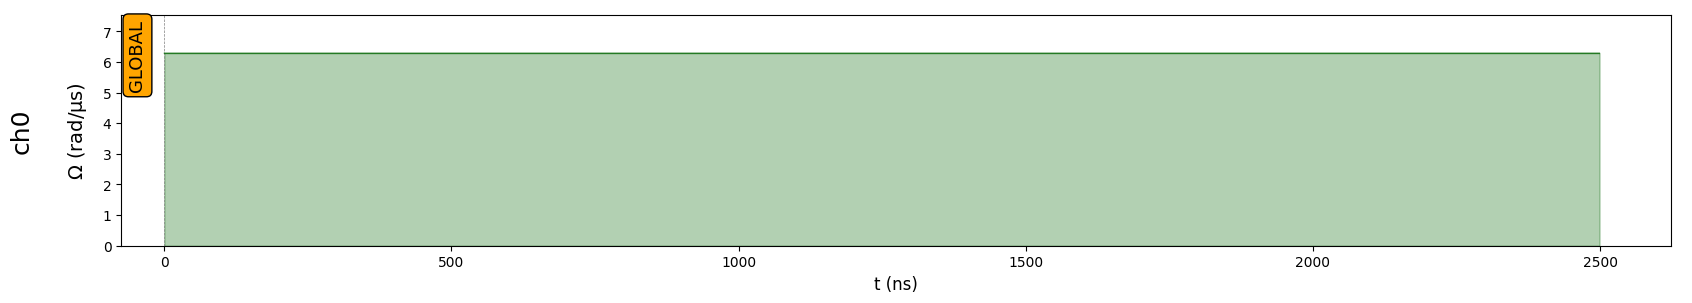

In [20]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ch0", "rydberg_global")
duration = 2500
pulse = Pulse.ConstantPulse(duration, 2 * np.pi, 0.0, 0.0)
seq.add(pulse, "ch0")
seq.draw()

In order to characterize simuation results, we designed a dedicated class, the `SimulationResults` class. It has two child class, the `CoherentResults` for noiseless simulations and `NoisyResults` for noisy simulations.

We now run the noiseless simulation, to obtain a `CoherentResults` object in `clean_res`.  They allow to get useful information on the simulation parameters, the results of the simulation and more.

In [21]:
sim = Simulation(seq, sampling_rate=0.05)
clean_res = sim.run()

We can for example plot the expectation values of an observable across time

In [26]:
# Define Rydberg state observable
obs = qutip.basis(2, 0).proj()

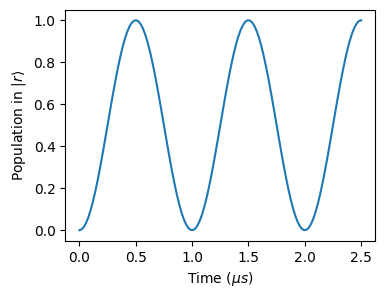

In [31]:
plt.figure(figsize=(4, 3))
plt.plot(clean_res._sim_times, clean_res.expect([obs])[0])
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"Population in $|r\rangle$")
plt.show()

### The SimConfig object

Each simulation has an associated `SimConfig` object, which encapsulates parameters such as noise types, the temperature of the register and so on. You may view it at any time using the following command.

In [8]:
sim.show_config()

Options:
----------
Number of runs:        15
Samples per run:       5


When creating a new `SimConfig`, you may choose several parameters. `'runs'` indicates the number of times a simulation is run to obtain the average result of all the simulations. `'samples_per_run'` is the number of delivered samples per run - this has no physical interpretation, this is used simply to cut down on calculation time.

### SPAM noise use case

We will use as a toy example the `SPAM` noise and add it to our simulation in order to describe the different objects used for noisy simulations. To do so, we can create a new `SimConfig` object, and assigning it to the `config` field of `sim` via the `Simulation.set_config` setter. We pass noise types as a tuple of strings to a SimConfig object.

You can see the different noises implemented on pulser using `config.supported_noises` as follows

In [9]:
sim.config.supported_noises

{'ising': {'SPAM',
  'amplitude',
  'dephasing',
  'depolarizing',
  'doppler',
  'eff_noise'},
 'XY': {'SPAM'}}

By default, all config class are in the `ising` mode, allowing a wide range of noises. However, for some applications, we need to operate in the `XY` mode. In such cases, some noises can no more interact with the system. Only the SPAM noise is relevant.

Let's come back to our toy example. We add SPAM noise to our clean simulation.

In [10]:
config_spam = SimConfig(noise=("SPAM"), runs=30, samples_per_run=5)
sim.set_config(config_spam)

There must be additional information in the configuration of our simulation

In [11]:
sim.show_config()

Options:
----------
Number of runs:        30
Samples per run:       5
Noise types:           SPAM
SPAM dictionary:       {'eta': 0.005, 'epsilon': 0.01, 'epsilon_prime': 0.05}


Note that `SimConfig.spam_dict` is the spam parameters dictionary. `eta` is the probability of a badly prepared state, `epsilon` the false positive probability, `epsilon_prime` the false negative one.

When dealing with a `SimConfig` object with different noise parameters from the config in `Simulation.config`, you may "add" both configurations together, obtaining a single `SimConfig` with all noises from both configurations - on the other hand, the `runs` and `samples_per_run` will always be updated. This adds simulation parameters to noises that weren't available in the former `Simulation.config`. Noises specified in both `SimConfigs` will keep the noise parameters in `Simulation.config`. Try it out with `Simulation.add_config`:

In [12]:
cfg2 = SimConfig(
    noise=("SPAM", "dephasing", "doppler"),
    eta=0.8,
    temperature=1000,
    runs=50,
)
sim.add_config(cfg2)
sim.show_config()

Options:
----------
Number of runs:        50
Samples per run:       5
Noise types:           doppler, dephasing, SPAM
SPAM dictionary:       {'eta': 0.005, 'epsilon': 0.01, 'epsilon_prime': 0.05}
Temperature:           1000.0µK
Dephasing probability: 0.05


Note that we set the temperature in $\mu K$. We also observe that the `eta` parameter wasn't changed, since both `SimConfig` objects had `'SPAM'` as a noise model already. This feature might be useful when running several simulations with distinct noise parameters to observe the influence of each noise independtly, then wanting to combine noises together without losing your tailored noise parameters.

We created a noisy simulation using `set_config` and `add_config` methods of the the Simulation class. But it's not the only way, you can directly create a noisy simulation when you create your simulation object.

In [13]:
sim = Simulation(
    seq,
    sampling_rate=0.05,
    config=SimConfig(
        noise=("SPAM", "dephasing", "doppler"),
        temperature=1000,
        runs=50,
    ),
)
sim.show_config()

Options:
----------
Number of runs:        50
Samples per run:       5
Noise types:           SPAM, dephasing, doppler
SPAM dictionary:       {'eta': 0.005, 'epsilon': 0.01, 'epsilon_prime': 0.05}
Temperature:           1000.0µK
Dephasing probability: 0.05


### Setting evaluation times

As a `Simulation` field, `eval_times` refers to the times at which the result have to be returned. Choose `'Full'` for all the times the Hamiltonian has been sampled in the sequence, a list of times of your choice (has to be a subset of all times in the simulation), or a real number between $0$ and $1$ to sample the full return times array. Here, we choose to keep $\frac{8}{10}$ of the Hamiltonian sample times for our evaluation times.

In [14]:
sim.evaluation_times = 0.5

We now obtain a `NoisyResults` object from our noisy simulation. This object represents the final result as a probability distribution over the sampled bitstrings, rather than a quantum state `QObj` in the `CleanResults` case.

In [15]:
res = sim.run()

### Plotting noisy and clean results

The new `res` instance has similar methods to the usual `SimResults` object. For example, we can calculate expectation values. Observe how different the Rydberg population in the clean case and noisy case are : we clearly see a damping due to all the noises we added.

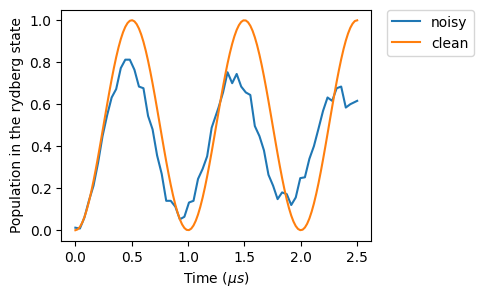

In [16]:
plt.figure(figsize=(4, 3))
plt.plot(res._sim_times, res.expect([obs])[0], label="noisy")
plt.plot(clean_res._sim_times, clean_res.expect([obs])[0], label="clean")
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel("Population in the rydberg state")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.show()

You can also use the `SimResults.plot(obs)` method to plot expectation values of a given observable. Here we compute the `sigma_z` local operator expectation values. You may choose to add error bars using the argument `error_bars = True` (`True` by default for `NoisyResults`.) Be wary that computing the expectation value of non-diagonal operators will raise an error, as `NoisyResults` bitstrings are already projected on the $Z$ basis.

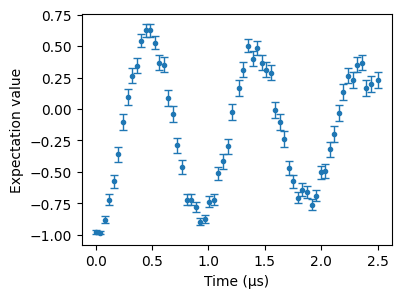

In [17]:
obs = qutip.sigmaz()
plt.figure(figsize=(4, 3))
res.plot(obs, fmt=".")  # If you don't want error bars set `error_bars=False`


Now you have the basic knowledge to tackle noise simulations with pulser. In the following tutorials, we will see in details *Simulations with SPAM errors*, *Simulations with laser noises* and *Simulations with effective noises*. Enjoy!